# DSGRN Query Functions

In [1]:
from DSGRN import *
database = Database("querytest.db")

In [2]:
database.parametergraph.dimension()

3L

We show here the network being considered in this example:

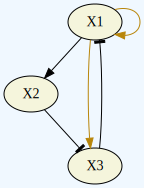

In [3]:
database

In [4]:
print(database.network.specification())

X1 : (X1)(~X3)
X2 : X1
X3 : (X1)(~X2)



# Query Overview

In order to perform queries on the database sometimes preprocessing is necessary. In order to give a uniform approach to this we have adopted a design where each query corresponds to a python class whose names ends with the suffix `Query`. Each class has a constructor (i.e. `__init__` method) which accepts some arguments to indicate parameters of the query (e.g. which database, 


We currently have the following queries:

| Name | Query Parameters | Query Input | Query Output |
| ---- | ----------- | ------------ | --- |
| MonostableQuery | Database | Morse Graph Index | True/False |
| BistableQuery |  Database |  Morse Graph Index | True/False |
| MultistableQuery |  Database | Morse Graph Index | True/False |
| SingleGeneQuery | Database, Name of Network Node | Reduced Parameter Index | Annotated Factor Graph |
| SingleFixedPointQuery |  Database, Domain Bounds |  Morse Graph Index | True/False |
| DoubleFixedPointQuery |  Database, pair of Domain Bounds |  Morse Graph Index | True/False |
| MonostableFixedPointQuery | Database, Domain Bounds |  Morse Graph Index | True/False |
| InducibilityQuery | Database, Name of Network Node, pair of Domain Bounds | Reduced Parameter Index | Triple of True/False |
| HysteresisQuery | Database, Name of Network Node, pair of Domain Bounds | Reduced Parameter Index | True/False |

When the query object is constructed, it is passed the required parameters and any preprocessing that is required to support the query is done. In some cases the preprocessing is trivial, and in other cases it may be more extensive. After the object is constructed, it can be used to perform queries. This is accomplished by invoking the objects `__call__` operator (i.e. treating the object as a function). The call operator receives the query input and returns the query output. For example:

```
single_gene_query = SingleGeneQuery(database, "X1")
graph = single_gene_query(43)
```

In the first line, the query object is created with the query parameters `database` and `"X1"`. This results in computation being done to organize a table in the database to quickly support "Single Gene Queries". The created object `single_gene_query` has a method `__call__` which allows it to be called as a function in order to produce query results. The input of the `__call__` method is a "reduced parameter index" and what is returned will be an annotated graph structure specific to what this query does.

In many cases the input to the query is a Morse Graph Index and the output is a boolean value which indicates whether or not the morse graph index is in a precomputed set of matches. These query classes typically also support another method `matches` which simply returns the set of matches. This allows the following code:

```
set_of_matches = SingleFixedPointQuery(database, domain_bounds).matches()
```

In this code, a query object is created, the `matches` method is called and returns the set of matches, but no reference to the query object is kept. When using this paradigm one should be careful not to unnecessarily create the same query multiple times, or else the same preprocessing step would be repeated. 



# MonostableQuery, BistableQuery, and MultistableQuery

In [5]:
monostable_query_object = MonostableQuery(database)
bistable_query_object = BistableQuery(database)
multistable_query_object = MultistableQuery(database)

Evaluate the query on a few Morse Graph Indices:

In [6]:
monostable_query_object(0)

True

In [7]:
monostable_query_object(1)

False

How many matches for each type of query?

In [8]:
print([len(monostable_query_object.matches()), len(bistable_query_object.matches()), len(multistable_query_object.matches())])

[45, 98, 110]


Print the list of Morse graph indices which satisfy the monostable query.

In [9]:
print(monostable_query_object.matches())

frozenset([0, 2, 3, 6, 9, 10, 11, 130, 18, 19, 20, 21, 153, 25, 26, 28, 30, 32, 34, 36, 38, 40, 43, 49, 50, 53, 55, 56, 59, 60, 74, 75, 78, 79, 89, 96, 131, 102, 104, 146, 113, 148, 122, 123, 127])


Directly verify that all returns matches satisfy the corresponding query:

In [10]:
all( monostable_query_object(mgi) for mgi in monostable_query_object.matches() )

True

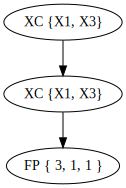

In [11]:
database.DrawMorseGraph(131)

# SingleGeneQuery

Our interest is in fixing all combinatorial parameters except for the logic parameter corresponding to a single node and considering the set of parameters corresponding to this choice. Due to the factorization of the parameter graph, this set of parameters is isomorphic to the factor graph associated to the node of interest. In order to handle repeated queries efficiently, it is necessary to prepare a table which reorders information so that it is I/O efficient for algorithms to retrieve. The following does this:

In [12]:
single_gene_query = SingleGeneQuery(database, "X1")

For a single gene query, the queries are graphs isomorphic to the factor graph, and the number of such queries corresponds to the number of "reduced parameter indices". This will be explained in more depth shortly. To help explain this we first examine the following computation:

In [13]:
N = single_gene_query.number_of_gene_parameters()
M = single_gene_query.number_of_reduced_parameters()
L = database.parametergraph.size()
print([N, M, N*M, L])

[50L, 108L, 5400L, 5400L]


Importantly, this factorization corresponds to a way to convert a parameter index (an integer) into a pair of integers, one in [0,50) and the other in [0,108), which we call the _gene parameter index_ and the _reduced parameter index_. The manner in which this is done is technical and has to do with how the integers encode combinatorial parameters using a mixed-radix system. Roughly speaking, the gene parameter index is obtained by extracting a digit from the mixed-radix representation of the parameter index, and what remains after removing the digit entirely (not just setting it to 0) is the reduced parameter index. This process can be reversed as well, so both the original parameter index and the (GeneParameterIndex, ReducedParameterIndex) pair are equivalent representations. What the prepare step we just accomplished did was create a table with the database's information which sorted the information by ReducedParameterIndex first and GeneParameterIndex second. (The original database sorts by ParameterIndex.)

## Performing a single-gene query

Now we perform a query. The result which the query returns is a graph. This graph contains data which has the raw information obtained from the query in the form of a python dictionary (i,e, `{key1:value1, key2:value2,...}`) where the keys are gene parameter indices, and the values are tuples `(hexcode, parameter index, morsegraphindex)`

In [14]:
graph = single_gene_query(43) # 43 is a "reduced parameter index"

In [15]:
graph.data

{0: ('000', 2150, 28),
 1: ('200', 2151, 28),
 2: ('208', 2152, 28),
 3: ('240', 2153, 40),
 4: ('248', 2154, 40),
 5: ('249', 2155, 40),
 6: ('600', 2156, 35),
 7: ('608', 2157, 35),
 8: ('618', 2158, 35),
 9: ('640', 2159, 94),
 10: ('648', 2160, 94),
 11: ('649', 2161, 94),
 12: ('658', 2162, 94),
 13: ('659', 2163, 94),
 14: ('6C0', 2164, 36),
 15: ('6C8', 2165, 36),
 16: ('6C9', 2166, 36),
 17: ('6D8', 2167, 36),
 18: ('6D9', 2168, 36),
 19: ('6DB', 2169, 36),
 20: ('E00', 2170, 53),
 21: ('E08', 2171, 53),
 22: ('E18', 2172, 54),
 23: ('E38', 2173, 58),
 24: ('E40', 2174, 104),
 25: ('E48', 2175, 104),
 26: ('E49', 2176, 104),
 27: ('E58', 2177, 105),
 28: ('E59', 2178, 105),
 29: ('E78', 2179, 106),
 30: ('E79', 2180, 106),
 31: ('EC0', 2181, 59),
 32: ('EC8', 2182, 59),
 33: ('EC9', 2183, 55),
 34: ('ED8', 2184, 55),
 35: ('ED9', 2185, 55),
 36: ('EDB', 2186, 55),
 37: ('EF8', 2187, 18),
 38: ('EF9', 2188, 18),
 39: ('EFB', 2189, 18),
 40: ('FC0', 2190, 59),
 41: ('FC8', 2191, 

The query above returns the "MorseGraphIndex" which can be used with the database to retrieve the Morse graph. However we might only want to know if the Morse graph has a certain property. For example, we might want to know if it has 1 minimal node, or multiple (2 or more) minimal nodes. We create a function which takes a "MorseGraphIndex" and returns True if the associated Morse graph has multiple minimal nodes and False otherwise.

## Visualizing the query

The above information describes a partially ordered set. In this poset each node corresponds to a parameter index. Each parameter index corresponds to a pair of sub-indices called the "GeneParameterIndex" and the "ReducedParameterIndex" which are the integers resulting from splitting out the "digit" corresponding to the logic parameter of the gene of interest. The "GeneParameterIndex" corresponds directly to the logic parameter of the gene of interest which can also be represented with a "HexCode". Using the hex code representation we learn adjacency information (due to the GPG=CPG theorem). Since our query gives us all of this information, the query automatically determines this information and can display itself as a graph of the labelled poset corresponding to the query. It also comes equipped with some methods for checking graph properties (as we demonstrate later). The nodes themselves are labelled according to their "ParameterIndex" and "MorseGraphIndex":

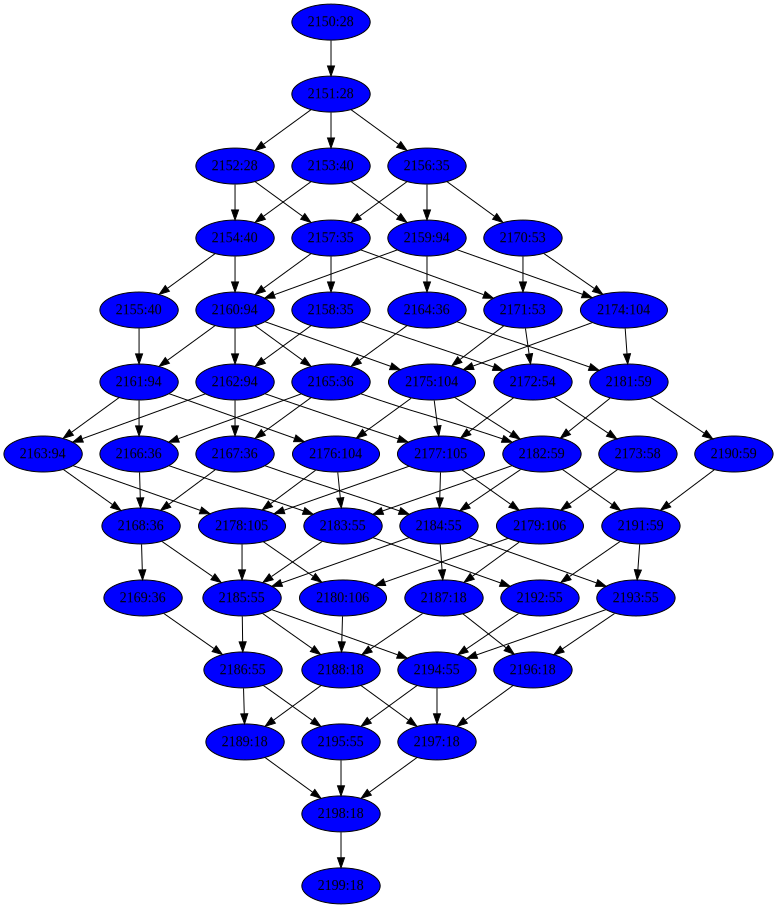

In [16]:
graph

## Features of the graph query
In addition to being a graph there are other attributes of the query that are of use. In particular, 

The graph is as follows: 

* The vertices of the graph (`graph.vertices`) are named according to Gene Parameter Index (gpi). 
* `graph.edges` contains the directed edge p -> q iff p < q and the associated logic parameters are adjacent.
* The graph is (by default) labelled with pairs (Parameter index, Morse graph index). The default graph labelling can be changed by replacing the `label` attribute with a new function. A `label` function takes the vertex name (i.e. gpi) as input and returns a label string.
* The graph is (by default) colored blue. The default graph coloring can be changed by replacing teh `color` attribute with a new function. A `color` function takes the vertex name as an input and returns a new color string.

In addition the following extra structures are provided:

* `graph.data` is a dictionary from gene parameter index to (hex code, parameter index, morse graph index)
* `graph.mgi` is a function which accepts a gpi and returns the associated Morse graph idnex
* `graph.num_inputs` is the number of network edges which are inputs to the gene associated with the query
* `graph.num_outputs`is the number of network edges which are outputs to the gene associated with the query
* `graph.essential` is a boolean-valued function which determines if each vertex corresponds to an essential parameter node


## Changing the color to inspect node properties

In the above graph all the nodes have the same color. We can change this so that the color of the nodes reflects some property of our choosing. As an example, we might ask if a node has a Morse graph with multistability -- if so, we can color the node red, otherwise we can color the node blue. This is done as follows:

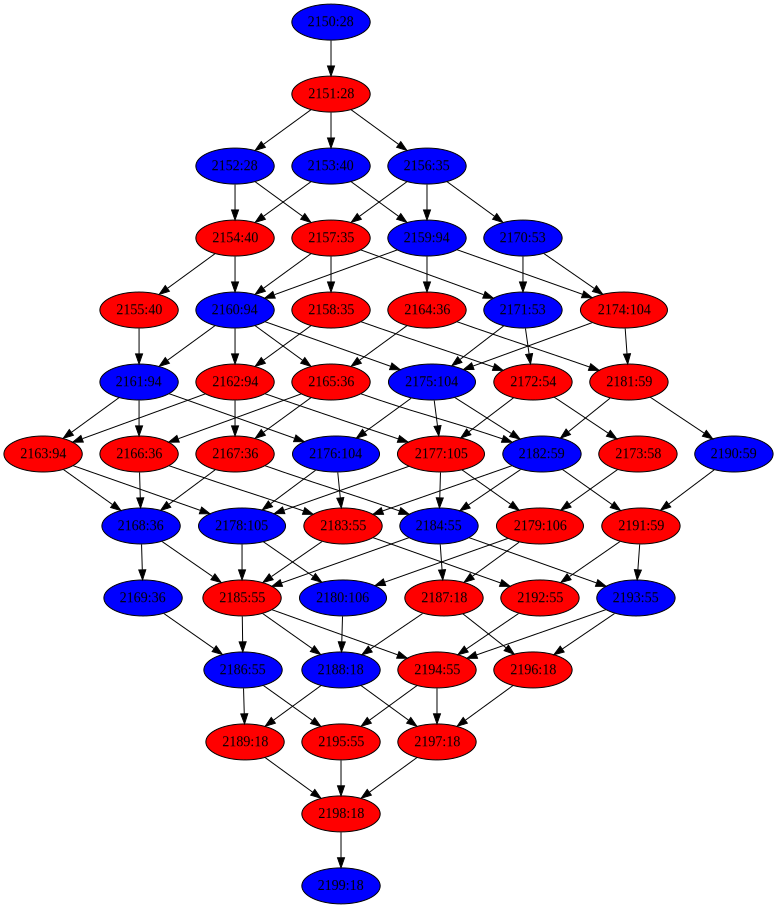

In [17]:
# Create a function which tells us if each vertex has the multistable property:
is_multistable = MultistableQuery(database)
# Change the coloring method of the graph to check for multistability:
graph.color = lambda v : "red" if is_multistable(v) else "blue"
# Display the graph:
graph

## Testing the query result

The above query indicates that some of the parameters associated with the query had multistability and some did not. In order to make sure everything is working properly, let's take an example of each class and draw the Morse graph. For instance, parameter index 2199 has Morse Graph 18, and is colored blue, which is supposed to correspond to a lack of multistability. We check this and find it is indeed the case:

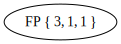

In [18]:
database.DrawMorseGraph(18)

Similarly, our query result indicates parameter index 2180 corresponds to Morse Graph 84, which is colored red, indicated it _does_ exhibit multistability. We check this as well:

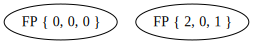

In [19]:
database.DrawMorseGraph(84)

# SingleFixedPointQuery, DoubleFixedPointQuery

We have the capability to retrieve parameter indices for which a FP occurs in a certain location. We call these locations "domains". A domain can be indicated by which "bin" it corresponds to along each dimension. A bin is an interval bounded by either (a) consecutive thresholds in a given dimension, (b) between 0 and the first threshold, or (c) bounded below by the last threshold and unbounded above. In particular, for each dimension the number of thresholds is equal to the number of out-edges of the corresponding network node. If there are m such thresholds then there are m+1 locations (bins) along this dimension which we label 0, 1, 2, ..., m. This allows us to describe the location of a domain by listing bin numbers for each dimension.

We can consider many domains at once which are grouped together in rectangular prisms. To represent these, we create a dictionary object where for each variable we product a key value pair where the key is the variable name and the value is a list of two integers [a,b] such that we mean that the variable can only occur in the bins between a and b (inclusive). If we omit a variable from the dictionary it is allowed to be in any bin. Also, if a=b we can simply write "a" instead of "[a,a]". For example:


In [20]:
bounds110 = {"X1":1,"X2":1,"X3":0} # Domain 1,1,0

In [21]:
bounds210 = {"X1":[2,2],"X2":[1,1],"X3":[0,1]}  # Domain 2,1,0 or Domain 2,1,1

In [22]:
bounds311 = {"X1":[3,3],"X2":[1,1],"X3":[1,1]} # Domain 3,1,1

Using these "bounds" variables to represent groups of domains, we can use query functions which ask for the collection of morse graphs which have an "FP" node labelled with a domain in those bounds. For example, to find the set of Morse Graph indices corresponding to fixed points in the region specified by "bounds110":

In [23]:
matches110 = SingleFixedPointQuery(database, bounds110).matches()

Find set of Morse Graph indices corresponding to fixed points in the region specified by "bounds210":

In [24]:
matches210 = SingleFixedPointQuery(database, bounds210).matches()

Find set of Morse Graph indices corresponding to fixed points in the region specified by "bounds311":

In [25]:
matches311 = SingleFixedPointQuery(database, bounds311).matches()

Find the set of Morse Graph indices with both a fixed point in 1,1,0 and a fixed point in 3,1,1:

In [26]:
matches_both = DoubleFixedPointQuery(database, bounds110,bounds311).matches()

In [27]:
len(matches110), len(matches210), len(matches311), len(matches_both)

(19, 29, 20, 2)

In [28]:
matches_both

{106, 116}

## Queries on Graph Properties

It is possible to make queries about graph properties. If we have developed a set of queries about the vertices, we can ask several kinds of questions:
1) Does the minimal node have a certain property?
2) Does the maximal node have a certain property?
3) Must every path from the minimal node to the maximal node pass through a node with a certain property?

We can even ask questions about how many paths from the minimal node to the maximal node have a certain property (or the fraction of paths). 

To help visualize the examples we color the graph "green", "blue", "red", and "yellow" according to each vertex's status with regard to the FP location query examples above. Specifically:

In [29]:
graph.color = lambda v : "green" if graph.mgi(v) in matches_both else ("blue" if graph.mgi(v) in matches210 else ( "yellow" if graph.mgi(v) in matches311 else "red"))

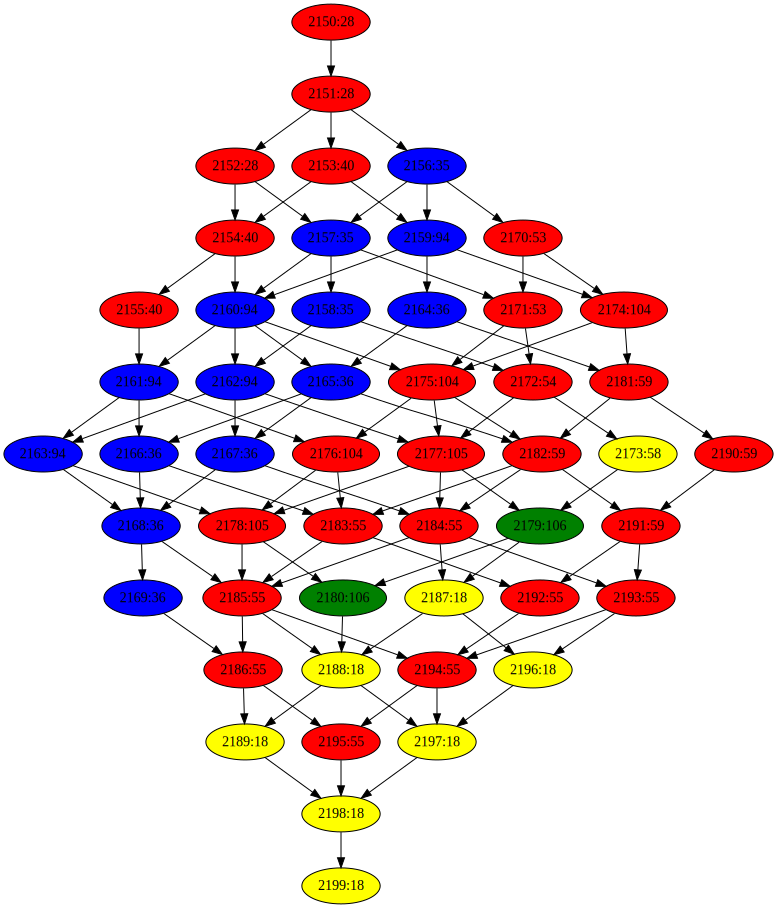

In [30]:
graph

In [31]:
minimum_gpi = 0
maximum_gpi = len(graph.vertices) - 1

### Q1. Is the minimal node red?

In [32]:
graph.color(minimum_gpi) == "red"

True

### Q2. Is the maximal node yellow?

In [33]:
graph.color(maximum_gpi) == "yellow"

True

### Q3(a). Is there an essential green node?

In [34]:
any( graph.essential(v) and graph.color(v) == "green" for v in graph.vertices) 

True

List all essential green nodes:

In [35]:
[v for v in graph.vertices if graph.essential(v) and graph.color(v) == "green"]

[29]

### Q3(b). Does every path from min to max pass through green?

In [36]:
predicate = lambda v : graph.color(v) == "green"
graph.unavoidable(minimum_gpi,maximum_gpi,predicate)

False

No, they don't. What percentage of them pass through green?

In [37]:
subgraph = graph.subgraph(lambda v : not predicate(v))
number_missing_green = subgraph.numberOfPaths(minimum_gpi,maximum_gpi)
total_number = graph.numberOfPaths(minimum_gpi,maximum_gpi)
print str((1.0 - float(number_missing_green)/float(total_number))*100.0) + "%" 

11.0929853181%


### Q3(b)'. Does every path from min to max pass through a blue vertex?

In [38]:
predicate = lambda v : graph.color(v) == "blue"
graph.unavoidable(minimum_gpi,maximum_gpi,predicate)

True

Which means there are zero paths from minimum to maximum in the subgraph where we take out the blue vertices, correct?

In [39]:
subgraph = graph.subgraph(lambda v : graph.color(v) != "blue")
if subgraph.numberOfPaths(minimum_gpi,maximum_gpi) == 0: print("Correct.")

Correct.


### Q3(c). Is there an intermediate (neither max nor min) green node?

In [40]:
any( v != minimum_gpi and v != maximum_gpi and graph.color(v) == "green" for v in graph.vertices)

True

## Visualizing the Essential parameter nodes:

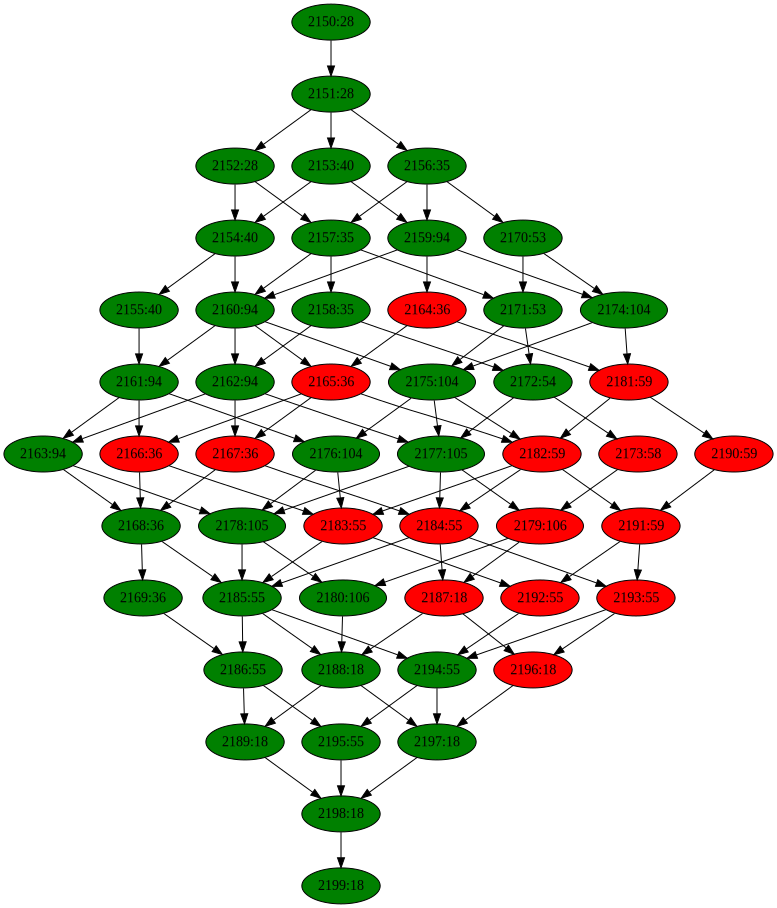

In [41]:
graph.color = lambda v : "red" if graph.essential(v) else "green"
graph

# InducibilityQuery

In [42]:
inducibility_query_object = InducibilityQuery(database, "X1", bounds110, bounds311)

In [43]:
reduced_parameters = range(0, inducibility_query_object.GeneQuery.number_of_reduced_parameters())

In [44]:
[ inducibility_query_object(rpi) for rpi in reduced_parameters ][0:10]

[(False, False, False),
 (False, False, False),
 (False, False, False),
 (False, False, False),
 (False, False, False),
 (False, False, False),
 (False, False, False),
 (False, True, False),
 (False, True, False),
 (False, False, False)]

# HysteresisQuery

In [45]:
hysteresis_query_object = HysteresisQuery(database, "X1", bounds110, bounds311)

In [46]:
reduced_parameters = range(0, hysteresis_query_object.GeneQuery.number_of_reduced_parameters())

In [48]:
[ hysteresis_query_object(rpi) for rpi in reduced_parameters ][0:10]

[False, False, False, False, False, False, False, False, False, False]